# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="https://github.com/michelpf/fiap-ml-visao-computacional-detector-liveness/blob/master/notebook/imagens/liveness.jpg?raw=1">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and OpenCV.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Integrante 1             | RM 12345      | XIA |
| Integrante 2             | RM 12345      | XIA |
| Integrante 3             | RM 12345      | XIA |
| Integrante 4             | RM 12345      | XIA |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: 
Pensamos em utilizar a abordagem de reconhecimento facial que aprendemos em aula combinado com uma estratégia apresentada no primeiro link das referências.

Com essa estratégia organizaremos as imagens em dois diretórios, um com imagens reais e um com imagens fake. As imagens fake podem ser gravações via webcam de fotos e vídeos. Já no diretório com imagens reais, teremos somente a gravação da pessoa em frente a camera.

Após capturar as imagens, vamos separar em frames de poucos milisegundos.

Com esses frames faremos a identificação de região de interesse e reduzir a dimensionalidade das imagens.

Esses frames serão nos base de dados cujo target é o nome do diretório de origem, real ou fake.

Treinaremos 3 com as técnicas Eigenfaces, FisherFaceRecognizer e LBPHFaceRecognizer.

Nossa medida de acerto será a acurácia.

## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [1]:
!rm -rf trabalho_visao_computacional

In [2]:
!git clone https://github.com/michaeldouglas/mba_IA_ML-proj_int-grupo_b

Cloning into 'mba_IA_ML-proj_int-grupo_b'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 743 (delta 59), reused 70 (delta 26), pack-reused 622
Receiving objects: 100% (743/743), 69.41 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (278/278), done.
Updating files: 100% (206/206), done.


In [3]:
%cd mba_IA_ML-proj_int-grupo_b/Python/trabalho_visao_computacional/

/content/mba_IA_ML-proj_int-grupo_b/Python/trabalho_visao_computacional


## Importar as bibliotecas 

In [4]:
import numpy as np
import pandas as pd

import glob
from tqdm import tqdm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import seaborn as sns

import cv2

import math

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.svm import SVC

#Exibição na mesma tela do Jupyter
%matplotlib inline

import datetime
import dlib

from scipy.spatial import distance as dist

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

## Criando os diretórios de separação de frames

In [5]:
%mkdir notebook/imagens/fake/
%mkdir notebook/imagens/real/

## Obter frames do Vídeo Real

In [6]:
pathIn = "notebook/videos/real.mp4"
pathOut = "notebook/imagens/real/"


def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
        success,image = vidcap.read()
        if success:
            cv2.imwrite( pathOut + "frame_%d.jpg" % count, image)
            count = count + 1

extractImages(pathIn, pathOut)

## Obter frames do Vídeo reproduzido em frente a outra camera

In [7]:
pathIn = "notebook/videos/fake.mp4"
pathOut = "notebook/imagens/fake/"


def extractImages(pathIn, pathOut):
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    print(success)
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
        success,image = vidcap.read()
        if success:
            cv2.imwrite( pathOut + "frame_%d.jpg" % count, image)
            count = count + 1

extractImages(pathIn, pathOut)

True


## Visualização de frames de categorias distintas

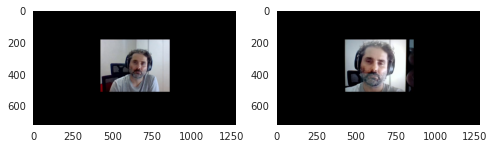

In [8]:
img1 = cv2.imread("notebook/imagens/real/frame_0.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("notebook/imagens/fake/frame_0.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

## Função para identificar faces utilizando o classificador HaarCascade

In [9]:
classificador_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def extrator_face_bgr(imagem):
    
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)
    
    if faces == ():
        return None
    
    for (x,y,w,h) in faces:
        roi = imagem[y:y+h, x:x+w]
    
    return roi

## Padronizações de tamanho e reduzção de dimensionalidade utilizando a escala gray

In [10]:
def padronizar_imagem(imagem):
    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem_gray = cv2.resize(imagem_gray, (200, 200), interpolation=cv2.INTER_LANCZOS4)
    return imagem_gray

## Imagem sem edição

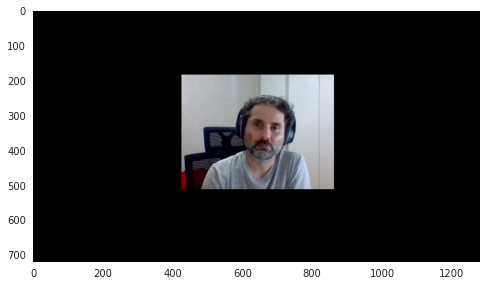

In [11]:
imagem = cv2.imread("notebook/imagens/real/frame_0.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem)

# Imagem transformada com a identificação de faces

<ipython-input-9-83daa23bc4dc>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


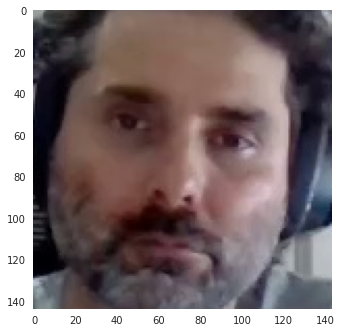

In [12]:
imagem = cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR)
roi = extrator_face_bgr(imagem)
roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
plt.imshow(roi)

## Imagem com a dimensionalidade reduzida

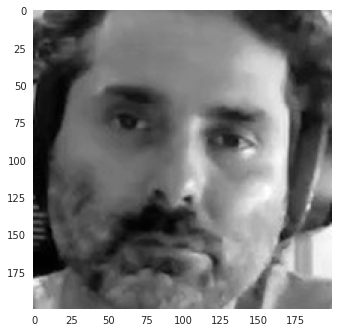

In [13]:
roi_gray = padronizar_imagem(roi)
plt.imshow(roi_gray, cmap="gray")

## Uma comparação entre a imagem original e um exemplo das imagens que servirão de modelo para treinamento de nossos modelos

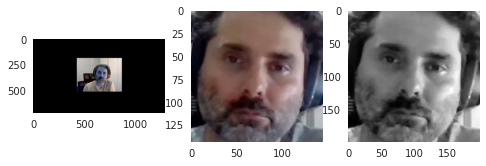

In [14]:
plt.subplot(1,3,1)
plt.imshow(imagem)
plt.subplot(1,3,2)
plt.imshow(roi)
plt.subplot(1,3,3)
plt.imshow(roi_gray, cmap="gray")

## Remoção de uma imagem que estava no template original para possibilitar a execução da função de tratamento de imagens

In [15]:
%rm notebook/imagens/liveness.jpg

## Tratamento dos frames obtidos dos vídeos de forma recursiva para obter a região de interesse(faces), utilizando o método extrator_face_bgr construido anteriormente.


In [16]:
import glob

for f in tqdm(glob.glob('notebook/imagens/**/*.jpg', recursive=True)):
  imagem = cv2.imread(f)
  face = extrator_face_bgr(imagem)

  if face is not None:

  #   # roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f.split("/")[0] + "/" + f.split("/")[1] + "/" + f.split("/")[2] + "/" + "proc_al_" + f.split("/")[3] , face)

  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-9-83daa23bc4dc>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():
100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


## Nessa etapa reduzimos a dimensionalidade das imagens utilizando o método padronizar_imagem e geramos as listas de imagens que serão as características do nosso modelos e a lista target, que identifica se a imagem é real ou fake.

In [17]:
lista_target = []
lista_imagens = []

for f in tqdm(glob.glob('notebook/imagens/**/proc_*.jpg', recursive=True)):
  lista_target.append(f.split("/")[2])
  imagem = cv2.imread(f)
  imagem = padronizar_imagem(imagem)
  lista_imagens.append(imagem)

100%|██████████| 25/25 [00:00<00:00, 736.81it/s]


In [18]:
set(lista_target)

{'fake', 'real'}

In [19]:
target = list(set(lista_target))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(lista_imagens, lista_target, test_size=0.3, random_state=42)
len(X_train),len(X_test), len(y_train), len(y_test)

(17, 8, 17, 8)

In [21]:
X_train = np.asarray(X_train, dtype=np.int32)
X_test = np.asarray(X_test, dtype=np.int32)

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(target)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

# Modelo Eigenfaces

In [23]:
modelo_eingenfaces = cv2.face.EigenFaceRecognizer_create()
modelo_eingenfaces.train(X_train, y_train)

# Modelo FisherFaceRecognizer

In [24]:
modelo_lda = cv2.face.FisherFaceRecognizer_create()
modelo_lda.train(X_train, y_train)

# Modelo LBPHFaceRecognizer

In [25]:
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(X_train, y_train)

### 4.3 Métricas de desempenho do modelo (2 pontos)

In [26]:
y_pred_eingenfaces = []

for item in tqdm(X_test):
    y_pred_eingenfaces.append(modelo_eingenfaces.predict(item)[0])
    
acuracia_eingenfaces = accuracy_score(y_test, y_pred_eingenfaces)
f"Acurácia com o modelo Eigenfaces: {acuracia_eingenfaces}"

100%|██████████| 8/8 [00:00<00:00, 712.83it/s]


'Acurácia com o modelo Eigenfaces: 1.0'

In [27]:
y_pred_lda = []

for item in tqdm(X_test):
    y_pred_lda.append(modelo_lda.predict(item)[0])
    
acuracia_lda = accuracy_score(y_test, y_pred_lda)
f"Acurácia com o modelo FisherFace: {acuracia_lda}"

100%|██████████| 8/8 [00:00<00:00, 4208.51it/s]


'Acurácia com o modelo FisherFace: 1.0'

In [28]:
y_pred_lbph = []

for item in tqdm(X_test):
    y_pred_lbph.append(modelo_lbph.predict(item)[0])
    
acuracia_lbph = accuracy_score(y_test, y_pred_lbph)
f"Acurácia com o modelo FisherFace: {acuracia_lda}"

100%|██████████| 8/8 [00:00<00:00, 202.78it/s]


'Acurácia com o modelo FisherFace: 1.0'

## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

In [29]:
imagem = cv2.imread("notebook/imagens/fake/frame_4.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
roi = extrator_face_bgr(imagem)
roi_padronizado = padronizar_imagem(roi)

predicao = modelo_lbph.predict(roi_padronizado)
predicao

<ipython-input-9-83daa23bc4dc>:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


(0, 21.628715547738842)

In [30]:
f"Essa imagem é {(le.inverse_transform([predicao[0]])[0]).capitalize()}"

'Essa imagem é Fake'

>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**: